In [10]:
import os

# Change to the root directory (one level up from 'test')
os.chdir('..')

In [11]:
folder_path = os.getcwd()
print(folder_path)

d:\Projects\News-Classification-on-multiple-neural-network-based-Architectures


In [12]:
import csv # Xử lý file csv
import tensorflow as tf # xử lý thư viện deep learning
import numpy as np # xử lý tính toán
from tensorflow.keras.preprocessing.text import Tokenizer # chuyển văn bản thành chuỗi số nguyên
from tensorflow.keras.preprocessing.sequence import pad_sequences # đảm bảo văn bản có cùng độ dài bằng cách thêm padding
from nltk.corpus import stopwords # import phần stopwords
import nltk # thư viện xử lý ngôn ngữ
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from collections import defaultdict
from sklearn.utils import resample
import numpy as np

In [13]:
from utils.label_encode import label_encode
from utils.compute_tf_idf import compute_tf_idf
from utils.randomized_svd import randomized_svd
from utils.train_test_split_manual import train_test_split_manual
from utils.random_oversample import random_oversample

In [14]:
# Đọc file CSV được tải lên
file_path = 'data/bbc-text.csv'
data = pd.read_csv(file_path)

In [15]:
# Hiển thị thông tin cơ bản của dữ liệu
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [16]:
from IPython.display import display

data_head = data.head()
# Hiển thị thông tin cơ bản của dữ liệu
display(data_head)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


C:\Users\Nam\AppData\Local\Temp\ipykernel_24820\2360224202.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


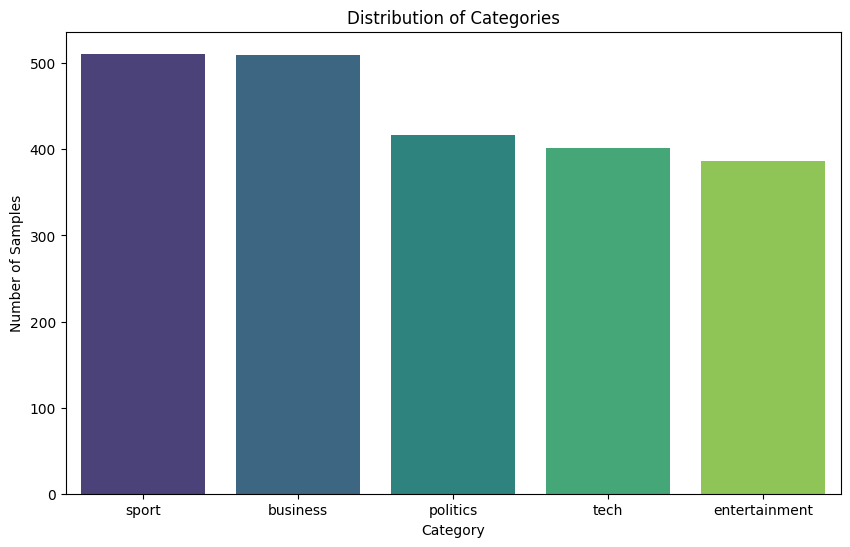

In [17]:
# Thống kê tổng quan về số lượng mẫu cho từng loại category
category_counts = data['category'].value_counts()

# Biểu đồ phân phối số lượng mẫu cho từng loại category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

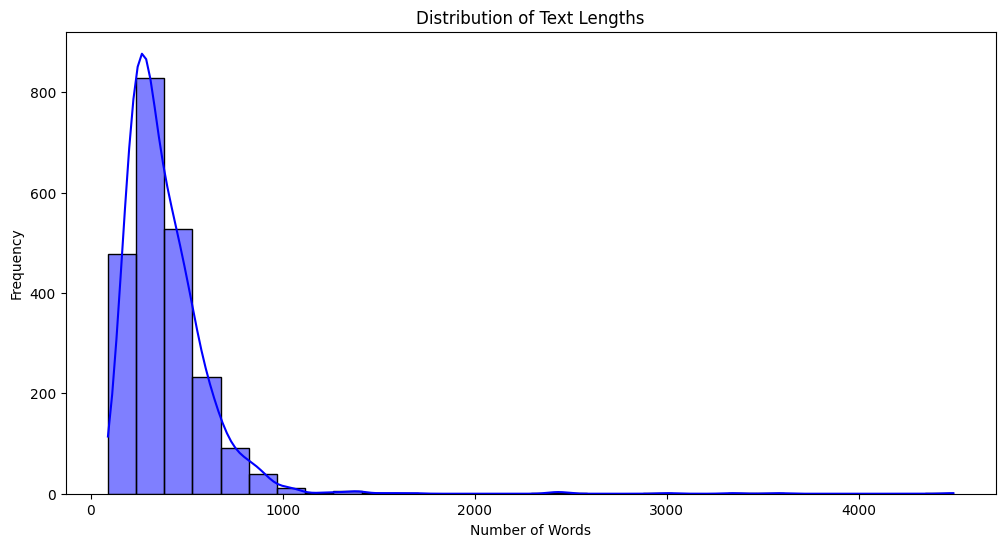

In [18]:
# Thống kê chiều dài của văn bản trong tập dữ liệu
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

# Biểu đồ phân phối chiều dài của văn bản
plt.figure(figsize=(12, 6))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

C:\Users\Nam\AppData\Local\Temp\ipykernel_24820\3992759342.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='text_length', data=data, palette='viridis')


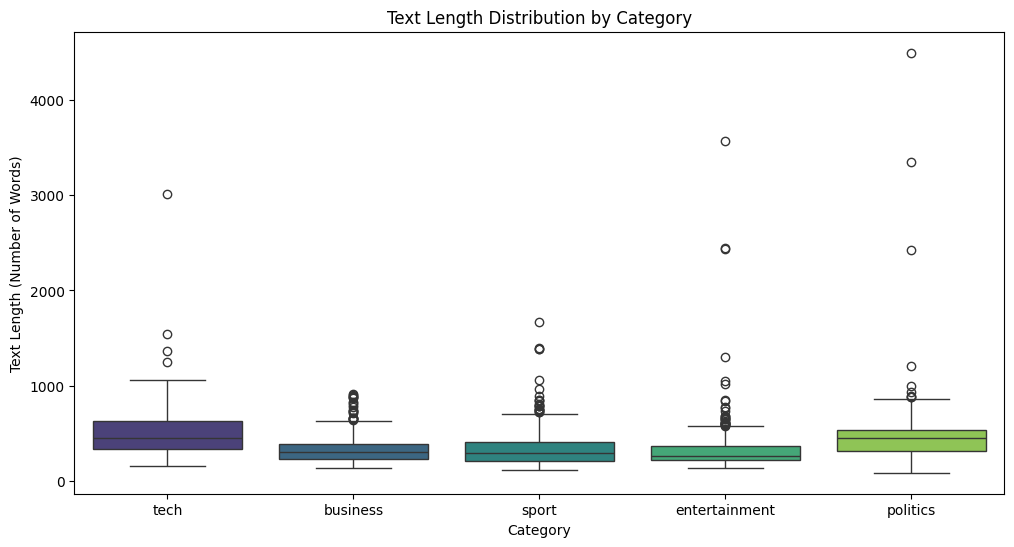

In [19]:
# Thống kê chiều dài văn bản cho từng loại category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='text_length', data=data, palette='viridis')
plt.title('Text Length Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Text Length (Number of Words)')
plt.show()

In [20]:
# Thống kê về số lượng từ duy nhất trong tập dữ liệu
unique_words = len(set(' '.join(data['text']).split()))
total_words = sum(data['text_length'])

unique_words, total_words, category_counts

(43771,
 868407,
 category
 sport            511
 business         510
 politics         417
 tech             401
 entertainment    386
 Name: count, dtype: int64)

In [21]:
# Đánh giá: 43771 Độ đa dạng từ vựng cao -> khó khăn trong việc học từ hiếm hoặc ít khi xuất hiện
# giảm chiều dữ liệu như tf-idf, hoặc embedding để biểu diễn từ
# 868407 từ -> dữ liệu khá lớn
# tech và entertainment có độ chênh lệch khá lớn, cân nhắc sử dụng oversampling hoặc undersampling để cân bằng dữ liệu

In [ ]:
vocab_size = 30000 # Giới hạn số lượng từ khác nhau mà Tokenizer sẽ giữ lại
embedding_dim = 16 # Mỗi từ trong từ điển được biểu diễn một vector có 16 chiều
max_length = 120 # Độ dài tối đa là 120 từ, nếu ít hơn thì padding, nếu hơn thì cắt bớt đi
trunc_type='post' # loại cắt ngắn (truncation). Với giá trị post, một chuỗi dài hơn, cắt ở cuối chuỗi
padding_type='post' # thêm ở cuối chuỗi
oov_tok = "<OOV>" # out-of-vocabulary: nếu không có trong từ điển 1000 từ, thay thế bằng token này
training_portion = 0.8 # 0.8 training, 0.2 testing

In [23]:
# Tải xuống tập dữ liệu stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Danh sách chứa câu và nhãn
sentences = []
labels = []

# Danh sách stopwords -> loại các từ không có ý nghĩa
stop_words = set(stopwords.words('english'))
print(f"Number of stopwords: {len(stop_words)}")

Number of stopwords: 179


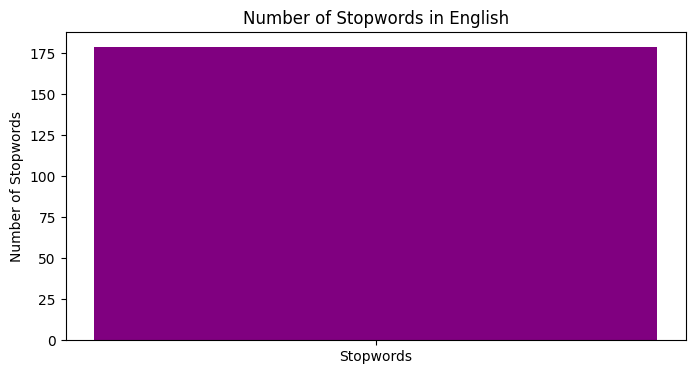

In [25]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
num_stopwords = len(stop_words)

plt.figure(figsize=(8, 4))
plt.bar(['Stopwords'], [num_stopwords], color='purple')
plt.title('Number of Stopwords in English')
plt.ylabel('Number of Stopwords')
plt.show()

In [26]:
with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Bỏ qua header
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        # Loại bỏ stopwords
        words = sentence.split()
        filtered_sentence = " ".join([word for word in words if word.lower() not in stop_words])
        sentences.append(filtered_sentence)

print(f"Number of labels: {len(labels)}")
print(f"Number of sentences: {len(sentences)}")
print(f"Example sentence: {sentences[0]}")

Number of labels: 2225
Number of sentences: 2225
Example sentence: tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us tivo uk sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take europe lack high-definition programming. people forward wind adverts also forget abiding network channel schedules putting together a-la-carte entertai

Số lượng từ trước khi loại bỏ Stopwords: 501318
Số lượng từ sau khi loại bỏ Stopwords: 501318


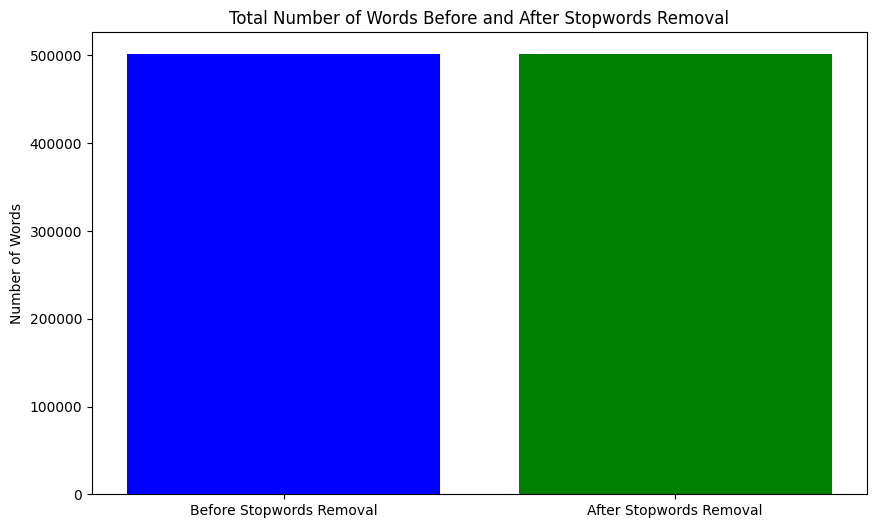

In [58]:
# Tạo tập dữ liệu không có stopwords
filtered_sentences = []
for sentence in sentences:
    words = sentence.split()
    filtered_sentence = " ".join([word for word in words if word.lower() not in stop_words])
    filtered_sentences.append(filtered_sentence)

# Số lượng từ trước và sau khi loại bỏ stopwords
total_words_before = sum([len(sentence.split()) for sentence in sentences])
total_words_after = sum([len(sentence.split()) for sentence in filtered_sentences])

print('Số lượng từ trước khi loại bỏ Stopwords:', total_words_before)
print('Số lượng từ sau khi loại bỏ Stopwords:', total_words_after)

# Biểu đồ so sánh
plt.figure(figsize=(10, 6))
plt.bar(['Before Stopwords Removal', 'After Stopwords Removal'], 
        [total_words_before, total_words_after], color=['blue', 'green'])
plt.title('Total Number of Words Before and After Stopwords Removal')
plt.ylabel('Number of Words')
plt.show()


In [29]:
X = compute_tf_idf(sentences, max_features=10000)

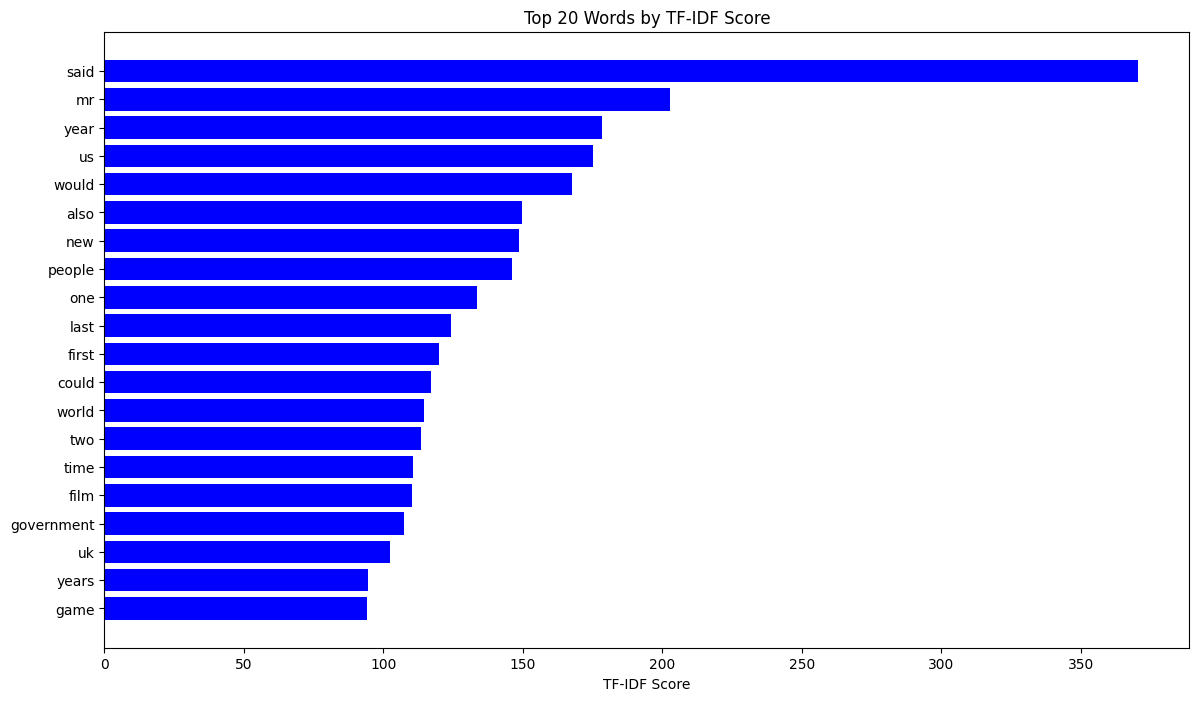

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf = TfidfVectorizer(max_features=100)
X_tfidf = tfidf.fit_transform(filtered_sentences)
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), X_tfidf.sum(axis=0).tolist()[0]))

# Sắp xếp từ theo điểm TF-IDF
sorted_tfidf = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)

# Chọn 20 từ có điểm TF-IDF cao nhất
top_n_words = 20
top_words, top_scores = zip(*sorted_tfidf[:top_n_words])

# Biểu đồ các từ có điểm TF-IDF cao nhất
plt.figure(figsize=(14, 8))
plt.barh(top_words, top_scores, color='blue')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()

In [31]:
y, label_mapping = label_encode(labels)

C:\Users\Nam\AppData\Local\Temp\ipykernel_24820\2360224202.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


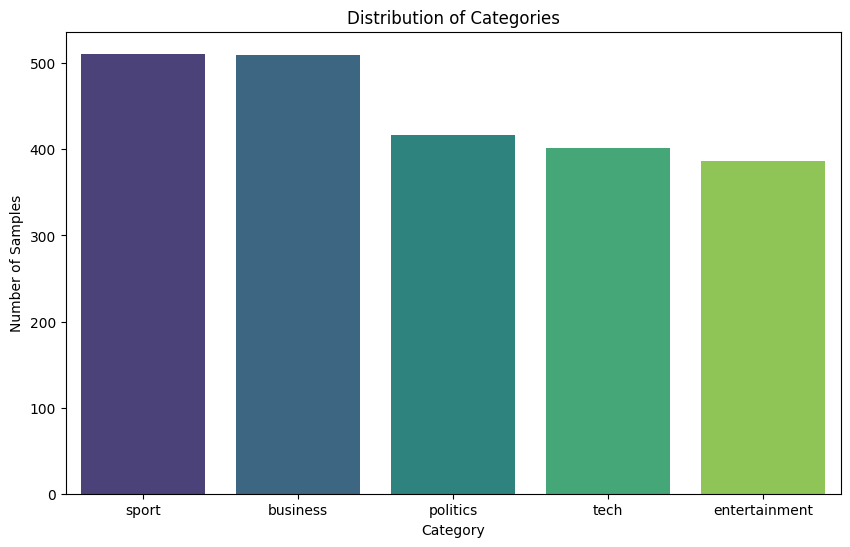

In [32]:
# Thống kê tổng quan về số lượng mẫu cho từng loại category
category_counts = data['category'].value_counts()

# Biểu đồ phân phối số lượng mẫu cho từng loại category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

In [36]:
#Cân bằng dữ liệu thủ công
X_resampled, y_resampled = random_oversample(X, y)

In [37]:
# Sử dụng hàm SVD ngẫu nhiên để giảm chiều dữ liệu
X_reduced = randomized_svd(X_resampled, n_components=2)

In [38]:
# Chia dữ liệu thủ công
X_train, X_test, y_train, y_test = train_test_split_manual(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [39]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2044, 10000)
Shape of y_train: (2044,)
Shape of X_test: (511, 10000)
Shape of y_test: (511,)


In [40]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(len(word_index))

29699


In [41]:
train_sequences = tokenizer.texts_to_sequences(sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [42]:
# Chia lại dữ liệu đã pad thành tập huấn luyện và kiểm tra
X_train_padded, X_test_padded, y_train_padded, y_test_padded = train_test_split(train_padded, y, test_size=0.2, random_state=42)

In [43]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 16)        │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,558 (1.83 MB)

 Trainable params: 480,558 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
num_epochs = 30
history = model_1.fit(X_train_padded, y_train_padded, epochs=num_epochs, validation_data=(X_test_padded, y_test_padded), verbose=2)

Epoch 1/30
56/56 - 1s - 15ms/step - accuracy: 0.4022 - loss: 1.7458 - val_accuracy: 0.4337 - val_loss: 1.6797
Epoch 2/30
56/56 - 0s - 2ms/step - accuracy: 0.5062 - loss: 1.5624 - val_accuracy: 0.5596 - val_loss: 1.4447
Epoch 3/30
56/56 - 0s - 2ms/step - accuracy: 0.6713 - loss: 1.2417 - val_accuracy: 0.7213 - val_loss: 1.1176
Epoch 4/30
56/56 - 0s - 3ms/step - accuracy: 0.8584 - loss: 0.8681 - val_accuracy: 0.8629 - val_loss: 0.8030
Epoch 5/30
56/56 - 0s - 2ms/step - accuracy: 0.9511 - loss: 0.5550 - val_accuracy: 0.9124 - val_loss: 0.5664
Epoch 6/30
56/56 - 0s - 2ms/step - accuracy: 0.9820 - loss: 0.3427 - val_accuracy: 0.9326 - val_loss: 0.4159
Epoch 7/30
56/56 - 0s - 3ms/step - accuracy: 0.9893 - loss: 0.2149 - val_accuracy: 0.9461 - val_loss: 0.3255
Epoch 8/30
56/56 - 0s - 2ms/step - accuracy: 0.9944 - loss: 0.1404 - val_accuracy: 0.9483 - val_loss: 0.2718
Epoch 9/30
56/56 - 0s - 2ms/step - accuracy: 0.9978 - loss: 0.0961 - val_accuracy: 0.9506 - val_loss: 0.2383
Epoch 10/30
56/56 

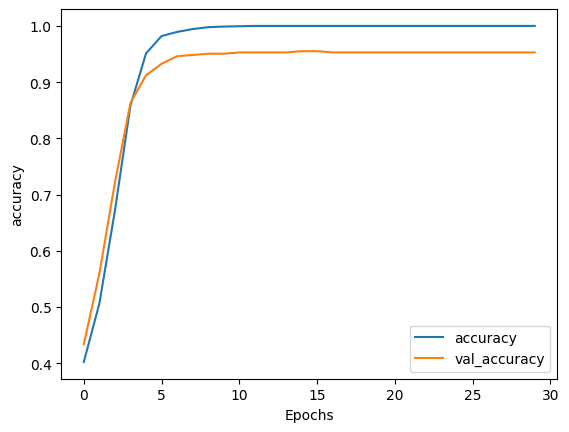

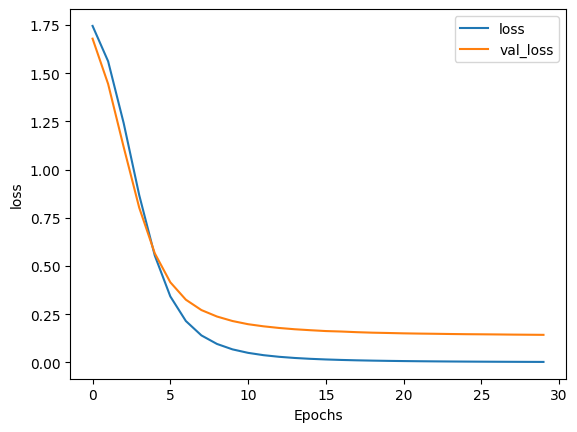

In [45]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [46]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 16)        │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,470 (1.86 MB)

 Trainable params: 486,470 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history2 = model_2.fit(X_train_padded, y_train_padded, epochs=num_epochs, validation_data=(X_test_padded, y_test_padded), verbose=2)

Epoch 1/30
56/56 - 2s - 37ms/step - accuracy: 0.2253 - loss: 1.6903 - val_accuracy: 0.2697 - val_loss: 1.5791
Epoch 2/30
56/56 - 1s - 17ms/step - accuracy: 0.3584 - loss: 1.4748 - val_accuracy: 0.3618 - val_loss: 1.4512
Epoch 3/30
56/56 - 1s - 16ms/step - accuracy: 0.5236 - loss: 1.1838 - val_accuracy: 0.5663 - val_loss: 1.1468
Epoch 4/30
56/56 - 1s - 18ms/step - accuracy: 0.6590 - loss: 0.9593 - val_accuracy: 0.6292 - val_loss: 0.9431
Epoch 5/30
56/56 - 1s - 19ms/step - accuracy: 0.8601 - loss: 0.6382 - val_accuracy: 0.7416 - val_loss: 0.7397
Epoch 6/30
56/56 - 1s - 20ms/step - accuracy: 0.9124 - loss: 0.3969 - val_accuracy: 0.7753 - val_loss: 0.6832
Epoch 7/30
56/56 - 1s - 18ms/step - accuracy: 0.9567 - loss: 0.2461 - val_accuracy: 0.8180 - val_loss: 0.5603
Epoch 8/30
56/56 - 1s - 16ms/step - accuracy: 0.9309 - loss: 0.2589 - val_accuracy: 0.7618 - val_loss: 0.6984
Epoch 9/30
56/56 - 1s - 16ms/step - accuracy: 0.9685 - loss: 0.1618 - val_accuracy: 0.8472 - val_loss: 0.5554
Epoch 10/3

In [ ]:
predictions = model_2.predict(X_train_padded)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


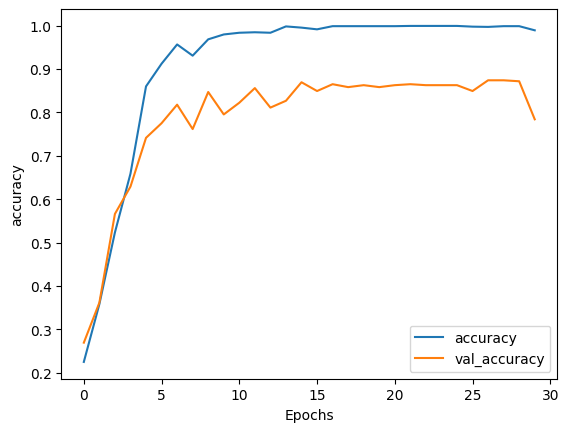

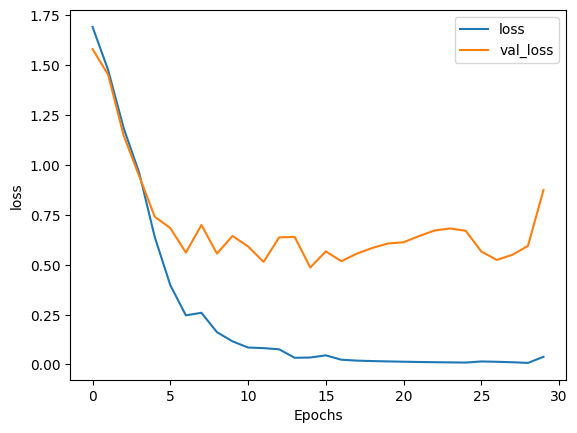

In [52]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [53]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 16)        │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 116, 64)        │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,598 (1.98 MB)

 Trainable params: 518,598 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history3 = model_3.fit(X_train_padded, y_train_padded, epochs=num_epochs, validation_data=(X_test_padded, y_test_padded), verbose=2)

Epoch 1/30
56/56 - 2s - 35ms/step - accuracy: 0.2326 - loss: 1.6477 - val_accuracy: 0.2202 - val_loss: 1.5952
Epoch 2/30
56/56 - 1s - 9ms/step - accuracy: 0.4893 - loss: 1.1906 - val_accuracy: 0.6494 - val_loss: 0.7970
Epoch 3/30
56/56 - 1s - 9ms/step - accuracy: 0.8674 - loss: 0.3841 - val_accuracy: 0.8697 - val_loss: 0.4318
Epoch 4/30
56/56 - 0s - 9ms/step - accuracy: 0.9635 - loss: 0.1393 - val_accuracy: 0.8831 - val_loss: 0.3733
Epoch 5/30
56/56 - 1s - 10ms/step - accuracy: 0.9820 - loss: 0.0726 - val_accuracy: 0.8809 - val_loss: 0.3639
Epoch 6/30
56/56 - 1s - 9ms/step - accuracy: 0.9972 - loss: 0.0237 - val_accuracy: 0.8764 - val_loss: 0.4406
Epoch 7/30
56/56 - 1s - 10ms/step - accuracy: 0.9921 - loss: 0.0311 - val_accuracy: 0.8674 - val_loss: 0.4255
Epoch 8/30
56/56 - 0s - 9ms/step - accuracy: 0.9989 - loss: 0.0104 - val_accuracy: 0.8899 - val_loss: 0.4158
Epoch 9/30
56/56 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8944 - val_loss: 0.4568
Epoch 10/30
56/5

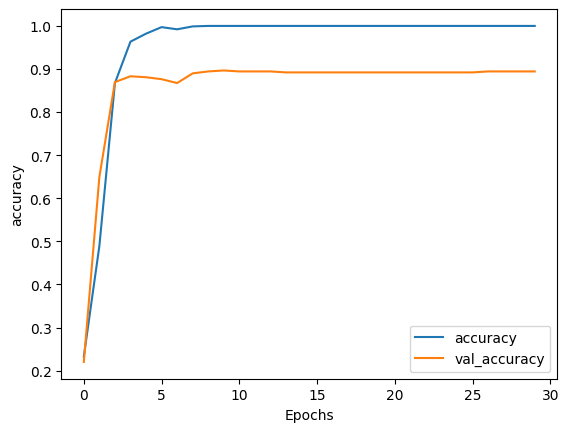

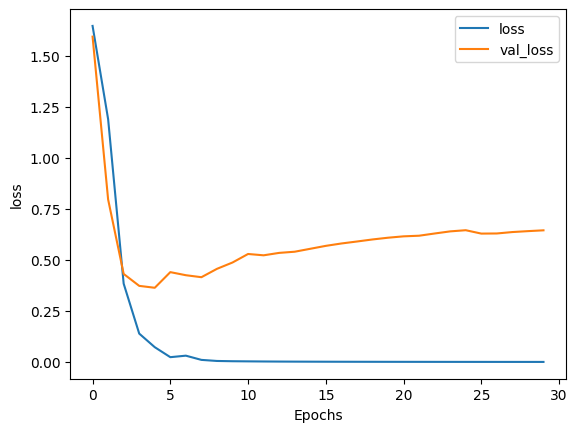

In [55]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

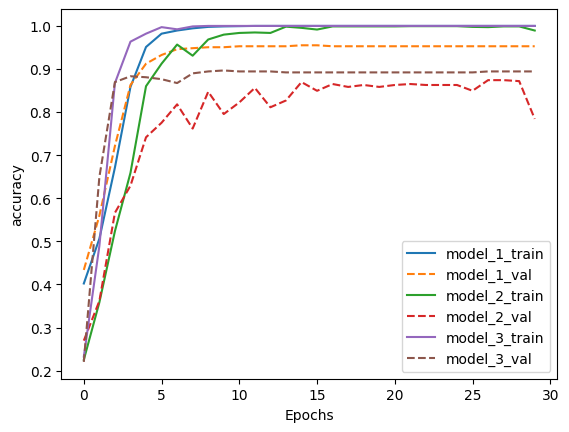

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_'+'accuracy'],'--')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_'+'accuracy'],'--')
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_'+'accuracy'],'--')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['model_1_train','model_1_val','model_2_train','model_2_val','model_3_train','model_3_val'])
plt.show()

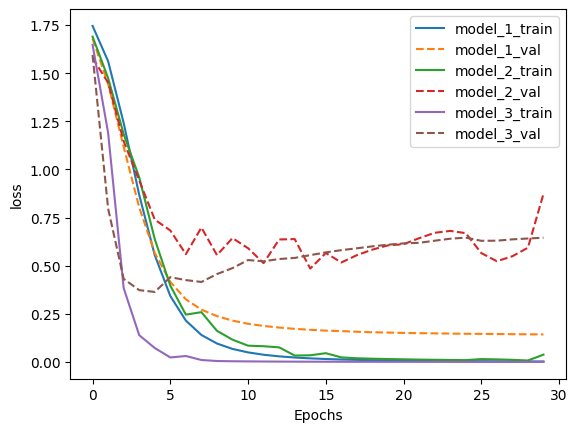

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_'+'loss'],'--')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_'+'loss'],'--')
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_'+'loss'],'--')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['model_1_train','model_1_val','model_2_train','model_2_val','model_3_train','model_3_val'])
plt.show()